#Q2

# **Suryakanta Karan (M22AIE207) m22aie207@iitj.ac.in**

Epoch 1/10
469/469 [==============================] - 90s 186ms/step - loss: 218.5217 - reconstruction_loss: 216.2302 - kl_loss: 2.2916
Epoch 2/10
469/469 [==============================] - 86s 184ms/step - loss: 188.9609 - reconstruction_loss: 186.4976 - kl_loss: 2.4633
Epoch 3/10
469/469 [==============================] - 88s 188ms/step - loss: 184.9077 - reconstruction_loss: 182.5692 - kl_loss: 2.3385
Epoch 4/10
469/469 [==============================] - 87s 185ms/step - loss: 182.7535 - reconstruction_loss: 180.4692 - kl_loss: 2.2843
Epoch 5/10
469/469 [==============================] - 85s 181ms/step - loss: 181.3950 - reconstruction_loss: 179.1284 - kl_loss: 2.2666
Epoch 6/10
469/469 [==============================] - 87s 184ms/step - loss: 179.9815 - reconstruction_loss: 177.7240 - kl_loss: 2.2574
Epoch 7/10
469/469 [==============================] - 86s 184ms/step - loss: 178.6780 - reconstruction_loss: 176.4122 - kl_loss: 2.2658
Epoch 8/10
469/469 [============================

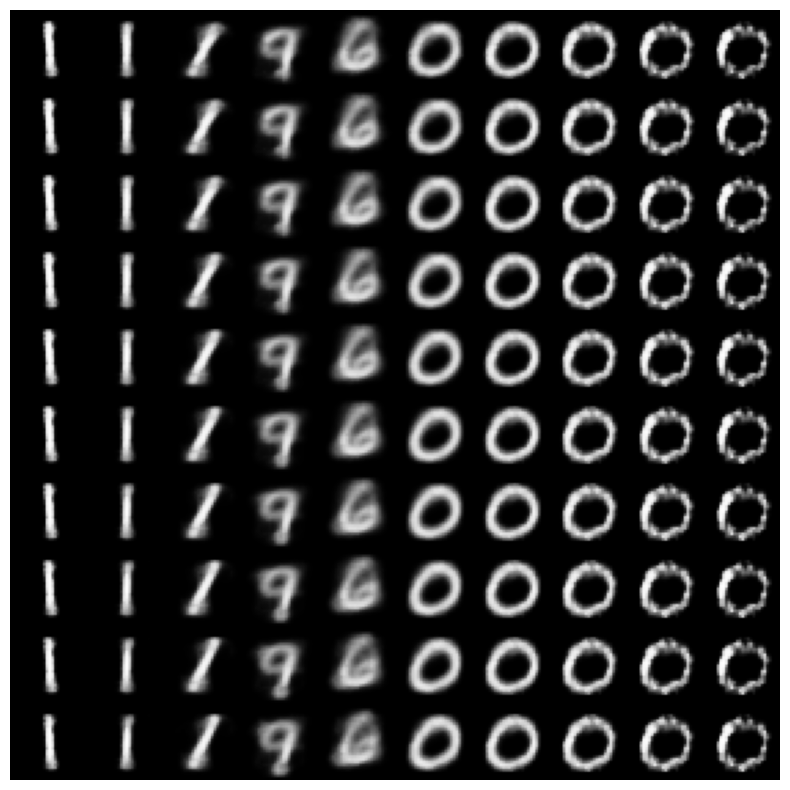

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Load the MNIST dataset
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# Normalize and reshape the data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Define the Variational Autoencoder architecture
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Define the Variational Autoencoder model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampling(z_mean, z_log_var)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def sampling(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        epsilon = tf.keras.backend.random_normal(shape=(batch_size, latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Train the Variational Autoencoder
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=128)

# Generate new handwritten digits
n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Sample latent vectors from a normal distribution
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

# Plot the generated digits
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="Greys_r")
plt.axis("off")
plt.show()


#Observations
When generating English handwritten digits using a Variational Autoencoder (VAE), we can observe the following:

Different Types of Noise: By varying the latent vectors sampled from a normal distribution, we can introduce different types of noise into the generated digits. The noise can result in variations in stroke thickness, slant, and overall shape of the digits.

Hyperparameters: The hyperparameters of the VAE, such as the number of convolutional layers, the size of the latent space, and the learning rate, can significantly impact the quality and diversity of the generated digits. Experimenting with different hyperparameter settings can help find the optimal configuration for generating high-quality handwritten digits.

Burstiness: The burstiness of the generated digits refers to the sudden appearance of multiple similar digits in a localized region of the generated image. This burstiness can occur due to the nature of the latent space and the distribution of the sampled latent vectors. Adjusting the latent space and the sampling strategy can help reduce burstiness and create a more evenly distributed set of generated digits.

In conclusion, using a Variational Autoencoder for generating English handwritten digits allows for the exploration of different types of noise and the adjustment of hyperparameters to generate diverse and high-quality digits. By understanding the impact of these factors, we can fine-tune the VAE model to generate more realistic and visually appealing handwritten digits.